# Japanese Character Recognition

This notebook is a revisit of an earlier project that leveraged neural networks for Japanese character recognition that implements better techniques. The previous iteration was rushed to check all the boxes for an MVP (while having the added burdon of building an app and a self generated dataset) and this document compares various improvements to the earier approaches with a more targetted and suitable approach to the task.

Unlike most other character recognition projects, this one uses character data that is entirely digitial by recording the strokes and component points logged while interacting with the canvas of an Android App. This provides several advantages that more traditional datasets do not offer:
* More compact storage of the data when stored as vectors of x and y coordinates
* Additional stroke order information is gained which can either be used directly in RNNs or represented by color shifts augmenting the inputs of a CNN.
* Contains additional stroke direction information that can derive additional features within an RNN.

This notebook will focus on correctly identifying characters from the standard hiragana monographs and digraphs with and without diacritic with 108 possible classes in total. In the future, there may be subsequent notebooks that expand to the Katakana and Kanji character sets, but those will less exploratory in nature and take on a more narrow approach with a more defined strategy.

## Setup

The majority of the code is contained within the src directory with the exception of explicit PyTorch model architecture definitions and any methods or classes that are unlikely to be firmly established for reuse in any subsequent notebooks.

In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd

PWD = os.getcwd()
sys.path.append(os.path.dirname(PWD))
from src import StrokeDataPaths, StrokeDataset, ToBSplines, ArrayToTensor, ExtractAngles, EmptyStrokePadder, CharacterTrainer, StrokesToPil, IncorrectCharacters, InputNormalizer, InputMinMaxTransformer, InputRecenter, StrokeDatasetAggregator, StrokeExtractAbsolute, InputGaussianNoise

#%matplotlib widget
%matplotlib inline

In [2]:
from torchvision.transforms import v2 as transforms
import torch
import torch.nn as nn
import torch.nn.functional as f

Present in the following cell are some methods to preserve reproduceability, but it is rendered mostly inneffective because a complete approach would break compatibility with pytorch's VGG16 implementation used in the transfer learning CNN. PyTorch's AdaptiveAvgPool2d layer currently does not support deterministic operations, so the code to force it on the GPU is disabled in order to optimize GPU performance instead of trying to meet a constraint that cannot be effectively met for all the presented architectures.

In [3]:
SEED = 1111
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
# Determinism is not supported by one of the layers in the VGG16 model
#torch.use_deterministic_algorithms(True, warn_only=True)
#os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

The path referring to the raw data currently points to a json file based dataset that is not stored on the repo, but it will be made available on HuggingFace at some time in the future.

In [4]:
# Stroring the common paths in variables
RAW_PATH = "../data/choubenkyo_data"
CLASS_PATH = "../choubenkyo_kivy_app/app/draw_screen/characters"
# While different characters contain different stroke counts, in order for them to easily work
# as tensors with fully random shuffling, they will need to be padded to a set maximum.
stroke_count = 10
batch_size = 20

To perform some basic EDA on this dataset, this cell instantiates two custom objects that simplify the loading of the raw data, labels, and additional metadata within the dataset.

In [5]:
# Custom class that serves as a bridge between the Dataset object and the file system. It manages paths and extracts information contained within structured filenames.
data_paths = StrokeDataPaths(RAW_PATH, CLASS_PATH)
# A custom dataset object that also allows the use of constraints based on a character's stroke count.
full_dataset = StrokeDataset(data_paths.get_data())

## Exploration

A few notebook-specific functions to reduce boilerplate code in plotting.

In [6]:
def common_plot_setup(figure=None, axes=None, palette=None, font=None, figsize=(15, 10), style=None, rows=1, cols=1):
    if style:
        plt.style.use(style)
    if font:
        plt.rcParams['font.family'] = font
    if palette:
        sns.set_palette(palette)
    if figure and axes:
        fig, ax = figure, axes
    else:
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    return fig, ax

def colors_from_values(values, palette_name):
    """Creates a palette that changes coloring of bar plots to vary by their y value"""

    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0).tolist()

### Dataset Overview

The custom dataset used in this notebook will be significantly improved from its first iteration. When the MVP was built, there wasn't any time available to spend to detect incorrect inputs that only serve to hinder the accuracy on the model.

Because the Japanese writing system has a defined structure regarding stroke order, the optimal application would be best served adhering to that structure especially when considering the idea of real time stroke by stroke character prediction that could have to deal with thousands of potential classes on a partially finished character. Generalizing to many different handwriting styles would still be advantageous, but the overall steps in drawing should be consistent.

The following code shows the overall size of the dataset and a table containing the amount of available obeservations for each character.

In [7]:
counts = pd.DataFrame(np.unique(full_dataset.labels, return_counts=True), index=["label", "count"]).T.set_index("label")
counts = counts.join(data_paths.get_classes(), how="left")
print("Total dataset size:", counts["count"].sum(), "drawn hiragana characters")
counts

Total dataset size: 6716 drawn hiragana characters


,count,label,char_id,character,romanization,stroke_count
label,,,,,,
0,60,hir_a,a,あ,a,3
1,60,hir_i,i,い,i,2
2,58,hir_u,u,う,u,2
3,59,hir_e,e,え,e,2
4,42,hir_o,o,お,o,3
...,...,...,...,...,...,...
103,62,hir_byu,byu,びゅ,byu,5
104,46,hir_byo,byo,びょ,byo,5
105,51,hir_pya,pya,ぴゃ,pya,5


Since the app was designed to randomly present characters for the capture of user input, there is moderate coverage of all classes. As expected, differences in counts follow a roughly normal distribution. Training would likely benefit slightly from some class balancing, but it would be more efficient to focus on integrating that more thoughtfully in a future notebook since the options presented here serve only as a comparative starting point. The evaluation metric will be the model's balanced accuracy score to better offset any advantages if the model were to favor the dominant classes.

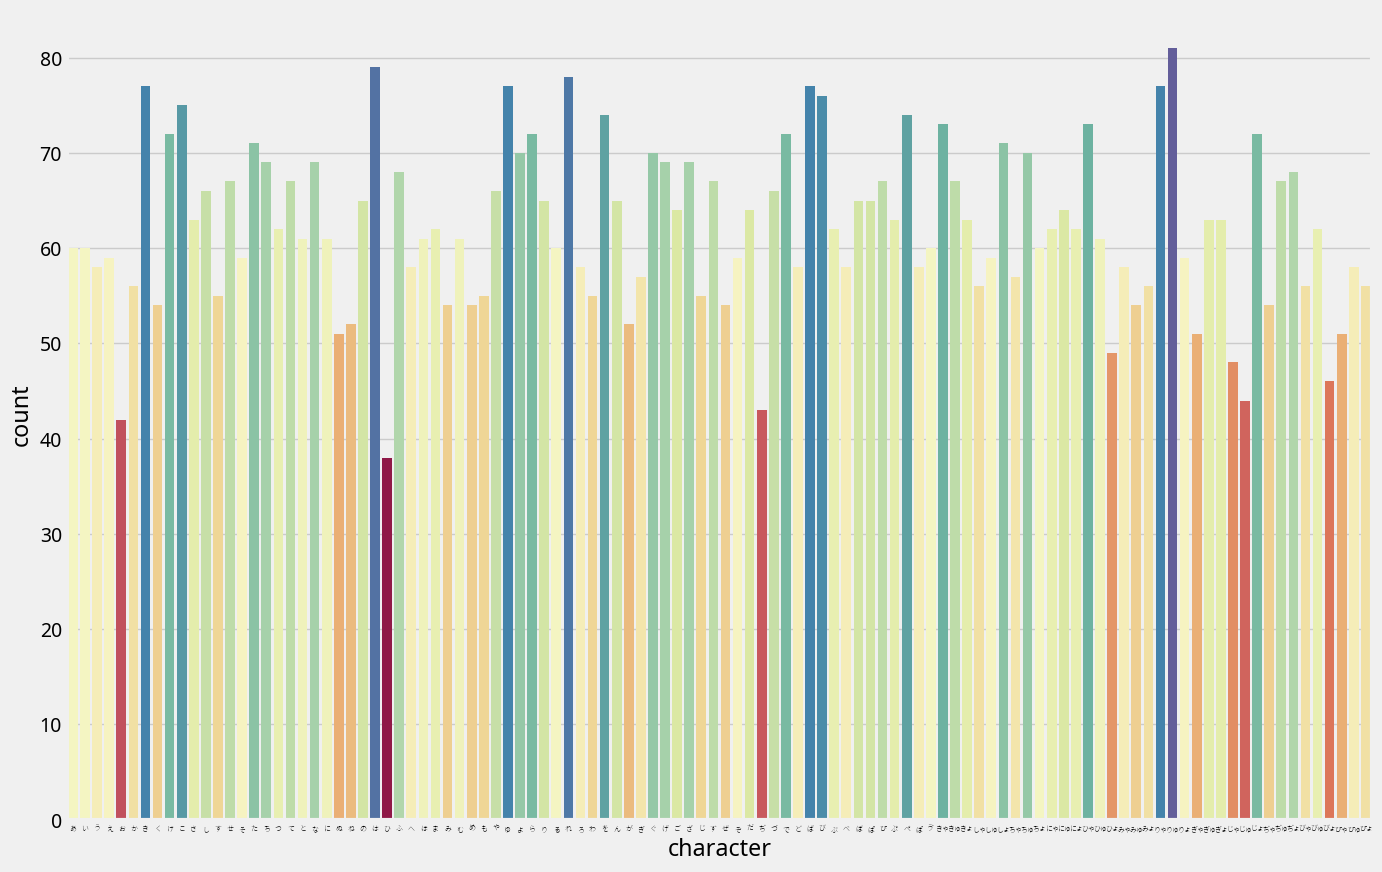

In [8]:
fig, ax = common_plot_setup(style="fivethirtyeight", font="Noto Sans")
sns.barplot(x = "character", y="count", data=counts, ax=ax, hue="character", palette=colors_from_values(counts["count"], "Spectral"), legend=False)
plt.xticks(fontname = "Noto Sans JP")
[item.set_fontsize(5) for item in ax.get_xticklabels()]
plt.show()

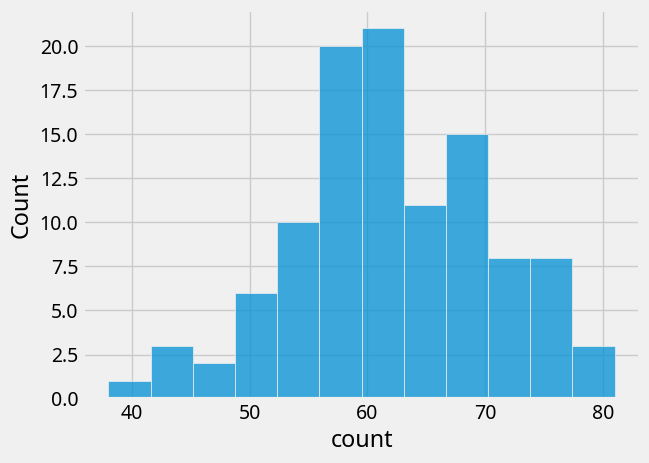

In [9]:
sns.histplot(counts["count"], bins=12)
plt.show()

In addition, the stroke count is very useful to know in order to best pad all tensors for use in batches. Here we will examine a rudimentary approach that just pads them with empty data to a maximum count of 10 strokes. There are likely significant improvements to be found in the real time detection use case if instead a form of variable truncating and padding were to be used instead. The implementation warrants further thought in how exactly it could be sampled in a way that favors completed characters while maintaining a good balance between classes.

In [10]:
stroke_counts = data_paths.get_data().groupby(["label", "stroke_count"]).count().groupby("stroke_count").count()
stroke_counts.columns = ["class_counts"]
stroke_counts

,class_counts
stroke_count,
1,11
2,20
3,24
4,21
5,19
6,9
7,3
8,1


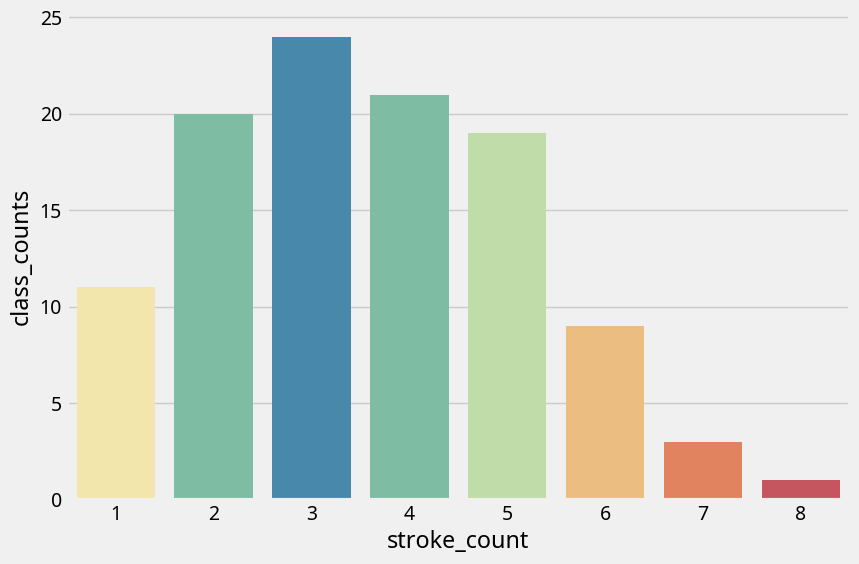

In [11]:
fig, ax = common_plot_setup(style="fivethirtyeight", font="Noto Sans", figsize=(9, 6))
sns.barplot(x = stroke_counts.index, y="class_counts", data=stroke_counts, ax=ax, hue=stroke_counts.index, palette=colors_from_values(stroke_counts["class_counts"], "Spectral"), legend=False)
plt.show()

### The Structure of a Single Datapoint

The canvas capturing app encodes the data in the form of a json containing a list of sequential x and y values for every stroke. During capture, the canvas is locked to a square aspect ratio and the device display sizes are normalized so that each coordinate can only range from -1 to 1 on either axis. The custom dataset object used here simply loads the json and orders the strokes sequentially into a nested list of (strokes, datapoints, x and y values).

In [12]:
example = full_dataset[-1]
print(data_paths._classes.iloc[example[1]])
example[0]

label           hir_zyu
char_id             zyu
character            じゅ
romanization         ju
stroke_count          5
Name: 97, dtype: object


[[[-0.6321307685640123, 0.834404706954956],
  [-0.6408074498176575, 0.8209269046783447],
  [-0.6662941310140822, 0.7689626216888428],
  [-0.6943145063188341, 0.6837601661682129],
  [-0.7131664951642355, 0.5885944366455078],
  [-0.747886233859592, 0.3708760738372803],
  [-0.7675962977939181, 0.22816967964172363],
  [-0.7724891437424554, 0.07062387466430664],
  [-0.7236234678162469, -0.19337773323059082],
  [-0.6915084852112664, -0.2613563537597656],
  [-0.661317937903934, -0.30898046493530273],
  [-0.6246270404921638, -0.35156917572021484],
  [-0.5735724833276536, -0.3908364772796631],
  [-0.5150567822986178, -0.4151954650878906],
  [-0.4497993654674954, -0.42128443717956543],
  [-0.38660042815738255, -0.4132080078125],
  [-0.34005363782246906, -0.3995366096496582],
  [-0.30849019686381024, -0.3901848793029785],
  [-0.2783587906095717, -0.3726654052734375],
  [-0.26539987987942165, -0.3557295799255371],
  [-0.17781886789533827, -0.19186925888061523]],
 [[-0.3957241111331516, 0.536188840

This raw data can easily be rendered to a raster and the ordering of strokes can be conveyed with a simple hue shift where the starting point is a pure red and the hue is adjusted by a set amount of degrees within its hsv representation for each subsequent stroke.

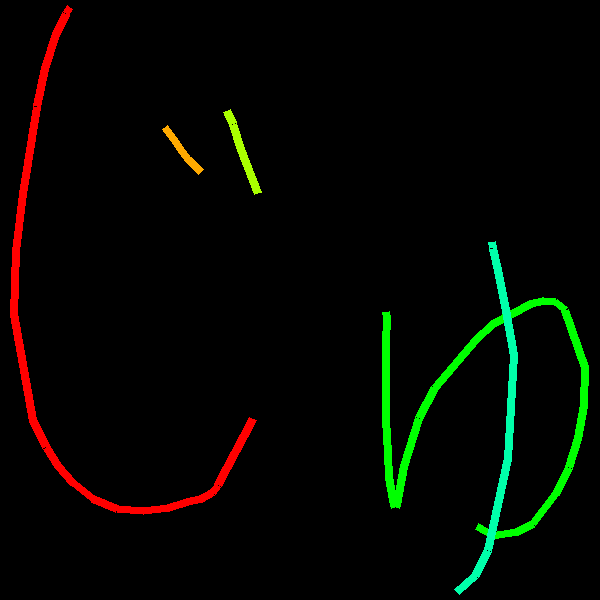

In [13]:
renderer = StrokesToPil((600, 600), stroke_width=8, invert_y=True, multicolor=True, mc_hue_shift=40)
renderer(example[0])

While the ragged datastructure of strokes with varying counts of points can be encoded easily in a raster image, using the raw coordinates is ill suited for the consistently shaped tensors necessary for an RNN. It's possible to pad the total amount of points to a consistent value, but there is no defined upper limit. The amount of points captured depends entirely on how long it takes to draw the stroke.

Because more informative features such as size and relative angles can be extracted from the coordinates alone, the temporal aspect in conjunction can be viewed almost as a form of noise that says more about the person drawing than the actual character itself. This could also increase the possibility of overfitting during training.

In order to simultaneously eliminate the need for empty points while also eliminating the temporal information encoded in the data, a transformation is applied for the RNN models where each individual stroke is represented by a uniformly lengthed b-spline interpolated from the sequence of x and y points. The cell below displays a visualization of the same datapoint, but this time using its b-spline representation. The two images are almost identical with the exception of a slight smoothing introduced from the addition of new points along the fitted curve (which in many cases may actually be a better representation of the drawer's intent).

In [14]:
b_spline_transformer = ToBSplines(120, 3, smooth_points=.5)

# Located in the cleaning functions python file, this function fixes the orientation and converts each raw points dictionary
# into a list of their interpolations along a b-spline.
example_b_spline = b_spline_transformer(example[0])

#The shaoe is consistent and the coordinates should be sufficient for each observation.
print(example_b_spline.shape)
    
#Looking at the first few datapoints in this notably long and complicated stroke, you can see that there are now more datapoints.
example_b_spline[0][0:10]

(5, 120, 2)


array([[-0.63213074,  0.83440471],
       [-0.63319596,  0.83321866],
       [-0.63548936,  0.82979721],
       [-0.63881829,  0.82434482],
       [-0.64299011,  0.81706598],
       [-0.64781219,  0.80816515],
       [-0.65309186,  0.79784683],
       [-0.65863649,  0.78631549],
       [-0.66425343,  0.77377559],
       [-0.66975656,  0.76043016]])

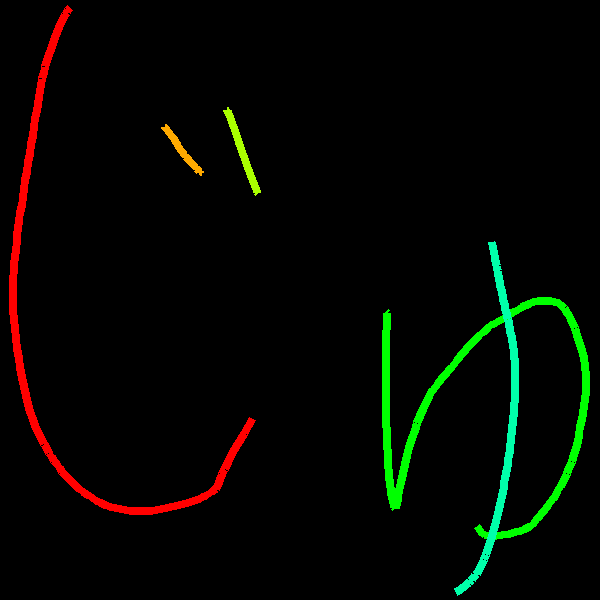

In [15]:
renderer(example_b_spline)

## Baseline: Dummy Classifier

A dummy classifier that predicts the dominant class is used to establish a prediction baseline.

In [16]:
def balanced_acc_baseline(X, y, strategy="prior", random_state=None):
    baseline = DummyClassifier(strategy=strategy, random_state=random_state)
    baseline.fit(X, y)
    y_pred = baseline.predict(X)
    acc = accuracy_score(y, y_pred)
    balanced_acc = balanced_accuracy_score(y, y_pred)
    print("Accuracy:", acc)
    print("Balanced Accuracy:", balanced_acc)

In [17]:
X = [item for item in full_dataset]
y = full_dataset.labels
balanced_acc_baseline(X, y, random_state=SEED)

Accuracy: 0.012060750446694461
Balanced Accuracy: 0.009259259259259259


## Model 1: CNN (VGG16)

The early prototype of the character identifier CNN explored the use of leveraging an existing hiragana/kanji dataset to facilitate transfer learning on the much smaller custom dataset. While in many cases this would be a great practice, this required the loss of features present in the custom data. By using an app to capture hand drawn input there is definitive information about stroke order and direction that would not be present in handwritten scans. The following model explores integrating stroke order through the use of hue shifted color channels.

To optimize training, transfer learning is directly applied using VGG16 weights trained on ImageNet. Because the training images are drastically different from the typical ImageNet classification objectives, the classifier layer is dropped entirely in favor of a more simplistic replacement and only the two lowest level convolutional layer groups are frozen.

In [18]:
import torchvision.models as models

cnn = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
# Freeze a;; layers in the CNN
for param in cnn.parameters():
    param.requires_grad = False
# Unfreeze the third block onwards for training.
for i in range(10, len(cnn.features)):
    for param in cnn.features[i].parameters():
        param.requires_grad = True

class ImageAggregator(StrokeDatasetAggregator):
    def __init__(self,
                 data_paths,
                 image_width,
                 stroke_width,
                 multicolor,
                 mc_hue_shift=40):
        trans =  transforms.Compose([StrokesToPil((image_width, image_width), stroke_width=stroke_width, invert_y=True, multicolor=multicolor, mc_hue_shift=mc_hue_shift), transforms.PILToTensor(), transforms.ToDtype(dtype=torch.float32, scale=True)])
        super().__init__(data_paths, trans, None)
        if multicolor:
            self._multicolor_reshape(image_width)

    def _multicolor_reshape(self, image_width):
        self._data = self._data.reshape(-1, 3, image_width, image_width).permute(0, 2, 3, 1).reshape(-1, 3)

To prepare the data with these weights, the inputs need to be normalized. The following cell extracts the rgb means and standard deviations from the entire dataset.

In [19]:
aggregator = ImageAggregator(data_paths, 224, 4, multicolor=True)
mean_rgb, std_rgb = aggregator.get_mean_std(dim=0)

Mean: tensor([0.0390, 0.0239, 0.0026])
STD: tensor([0.1890, 0.1414, 0.0468])


But because each stroke should be weighed equally, and because the hue rotation ensures that the red channel will be much more common than the other two, I opted to normalize the data using the mean and standard deviation across all color channels instead of each individually. Otherwise the presence of the blue channel appearing in later strokes would be a stronger input signal by a factor of 4.

In [20]:
aggregator = ImageAggregator(data_paths, 224, 4, multicolor=False)
mean_gray, std_gray = aggregator.get_mean_std()
norm = transforms.Normalize(mean=mean_gray.unsqueeze(-1).unsqueeze(-1), std=std_gray.unsqueeze(-1).unsqueeze(-1))

Mean: tensor(0.0489)
STD: tensor(0.2157)


Next, custom dataset and dataloader dictionaries are created with data augmentation occuring within only the training set.

In [21]:
# These transforms will be the common start to the train, val and test sets.
test_transforms = [StrokesToPil((32, 32), stroke_width=2, invert_y=True, multicolor=True, mc_hue_shift=40),
                   transforms.PILToTensor(),
                   transforms.ToDtype(dtype=torch.float32, scale=True),]
# Training dataset will be augmented by random transformations.
train_transforms = transforms.Compose(test_transforms + [transforms.RandomAffine(degrees=4, translate=(.1, .1), scale=(.9, 1.1), shear=.3), norm])
test_transforms = transforms.Compose(test_transforms + [norm])
transformed_dataset = StrokeDataset(data_paths.get_data(), transform=test_transforms)
split_keys = {"train": train_transforms, "val": test_transforms, "test": test_transforms}
# The dataset has a 70% train, 10% validation, and 20% test split.
split_datapaths = dict(zip(split_keys, data_paths.train_val_test_split(train_size=.7, test_size=.2, random_state=SEED)))
datasets = {key: StrokeDataset(split_datapaths[key], transform=value) for key, value in split_keys.items()}
dataloaders = {key: torch.utils.data.DataLoader(datasets[key], batch_size=batch_size, shuffle=True, num_workers=5, drop_last=True) for key in split_keys}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ffa132bed90>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7ffa132c9890>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ffa1bff6f10>}

The new classification layer consists of two Dense layers. The output of the first layer has a Relu activation function and a dropout layer for regularization. Finally like all of the subsequent models it uses the Softmax function to choose between the available classes. Also common to each model is cross entropy for the loss function, Adam for the optimizer, and a step scheduler to decay the learning rate.

In [22]:
# The input size of the previous classification layer group.
n_features = cnn.classifier[0].in_features
# Amount of classes to predict.
n_classes = np.unique(full_dataset.labels).size
print(n_classes)
dense_hidden = 40
learning_rate=0.00006
cnn.classifier = nn.Sequential(nn.Linear(n_features, dense_hidden), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(dense_hidden, n_classes))
#cnn.classifier[-1] = nn.Linear(n_features, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.4)

108


In [23]:
trainer = CharacterTrainer(cnn, optimizer, criterion, dataloaders, scheduler=scheduler, single_input=True)

In [24]:
%%time

trainer.train(40)
trainer.complete_results

       train_loss  train_acc  n_train  val_loss   val_acc  n_val       lr
epoch                                                                    
1        0.199804   0.102612   5372.0   0.11455  0.472727  448.0  0.00006
       train_loss  train_acc  n_train  val_loss   val_acc  n_val       lr
epoch                                                                    
2        0.117295   0.388246   5372.0  0.039384  0.843182  448.0  0.00006
       train_loss  train_acc  n_train  val_loss   val_acc  n_val       lr
epoch                                                                    
3        0.066997   0.625373   5372.0  0.017735  0.934091  448.0  0.00006
       train_loss  train_acc  n_train  val_loss   val_acc  n_val       lr
epoch                                                                    
4        0.051026   0.708582   5372.0  0.012627  0.945455  448.0  0.00006
       train_loss  train_acc  n_train  val_loss  val_acc  n_val       lr
epoch                                  

,train_loss,train_acc,n_train,val_loss,val_acc,n_val,lr
epoch,,,,,,,
1,0.199804,0.102612,5372,1.145504e-01,0.472727,448,0.000060
2,0.117295,0.388246,5372,3.938448e-02,0.843182,448,0.000060
3,0.066997,0.625373,5372,1.773462e-02,0.934091,448,0.000060
4,0.051026,0.708582,5372,1.262682e-02,0.945455,448,0.000060
5,0.042064,0.759701,5372,7.379494e-03,0.975000,448,0.000060
6,0.034712,0.793470,5372,7.104102e-03,0.965909,448,0.000060
7,0.030932,0.815485,5372,2.055051e-03,0.979545,448,0.000060
8,0.025177,0.846642,5372,1.502132e-03,0.993182,448,0.000060
9,0.025183,0.850187,5372,1.170390e-03,0.995455,448,0.000060


In [25]:
%%time

trainer.test()

       test_loss  test_acc  n_test        lr
epoch                                       
40      0.000146  0.998864   896.0  0.000004
CPU times: user 246 ms, sys: 258 ms, total: 504 ms
Wall time: 627 ms


,test_loss,test_acc,n_test,lr
epoch,,,,
40,0.000146,0.998864,896.0,0.000004


Despite the vary number of classes, the model proves very accurate with a near 100% balanced accuracy in character predictions.

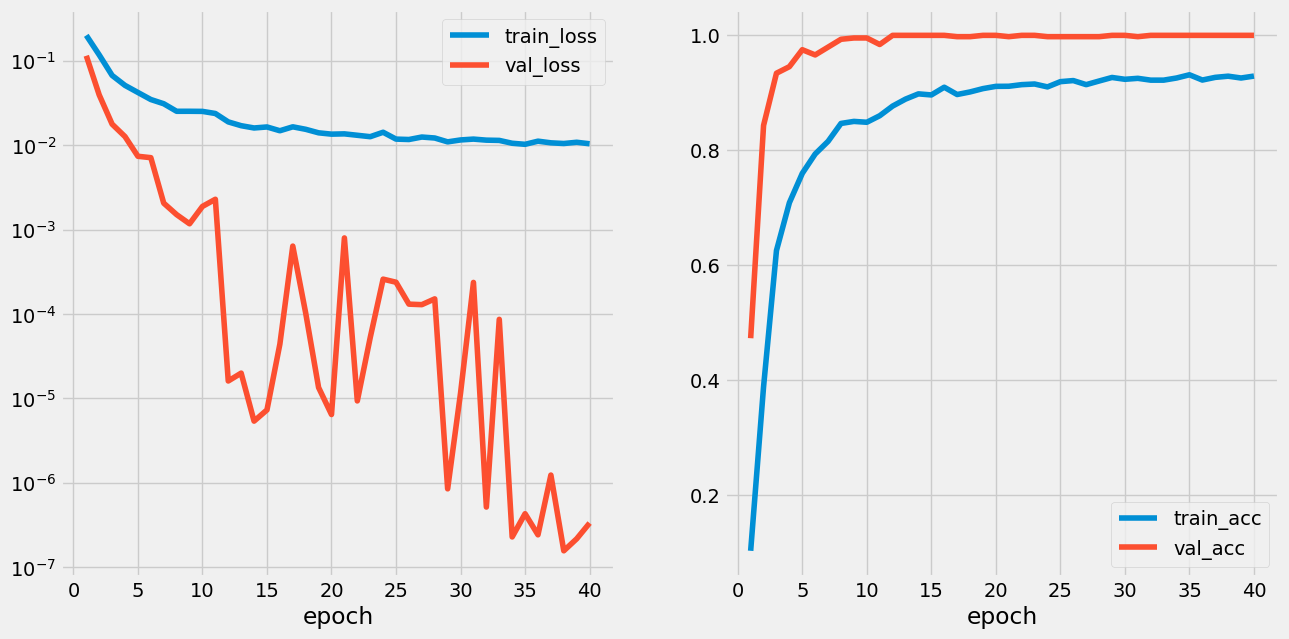

In [26]:
fig, [ax1, ax2] = common_plot_setup(style="fivethirtyeight", font="DejaVu Sans", figsize=(14, 7), rows=1, cols=2)
trainer.complete_results[["train_loss", "val_loss"]].plot(ax=ax1, logy=True)
trainer.complete_results[["train_acc", "val_acc"]].plot(ax=ax2, logy=False)
plt.show()

During this round of training the model only misclassified a single character. By examining the scaled outputs of the classification layer it is apparent that the model was mostly right but messed up on the character's diacritic mistaking the circular handakuten for the small pair of strokes that make up a dakuten. Even though stroke count was distinctly encoded in the rgb values it wasn't enough to be identified by the model.

In [27]:
misses = IncorrectCharacters(trainer, transformed_dataset, data_paths.get_classes())
print("Characters missed:", len(misses))
misses.overview(5)

Characters missed: 1


label  \
count label   char_id character romanization indices stroke_count strokes_found pred            
1     hir_bya bya     びゃ        bya          0       6            6.0           1     hir_pya   
                                                                                2     hir_bya   
                                                                                3     hir_kya   
                                                                                4     hir_zya   
                                                                                5       hir_e   

                                                                                      probability  \
count label   char_id character romanization indices stroke_count strokes_found pred                
1     hir_bya bya     びゃ        bya          0       6            6.0           1        0.925672   
                                                                                2        0.074299   
                                                                                3        0.000022   
                                                                                4        0.000004   
                                                                                5        0.000002   

                                                                                     char_id  \
count label   char_id character romanization indices stroke_count strokes_found pred           
1     hir_bya bya     びゃ        bya          0       6            6.0           1        pya   
                                                                                2        bya   
                                                                                3        kya   
                                                                                4        zya   
                                                                                5          e   

                                                                                     character  \
count label   char_id character romanization indices stroke_count strokes_found pred             
1     hir_bya bya     びゃ        bya          0       6            6.0           1           ぴゃ   
                                                                                2           びゃ   
                                                                                3           きゃ   
                                                                                4           じゃ   
                                                                                5            え   

                                                                                     romanization  \
count label   char_id character romanization indices stroke_count strokes_found pred                
1     hir_bya bya     びゃ        bya          0       6            6.0           1             pya   
                                                                                2             bya   
                                                                                3             kya   
                                                                                4              ja   
                                                                                5               e   

                                                                                     stroke_count  
count label   char_id character romanization indices stroke_count strokes_found pred               
1     hir_bya bya     びゃ        bya          0       6            6.0           1               5  
                                                                                2               6  
                                                                                3          6 or 7  
                                                                                4               6  
                                

## Model 2: Simple LSTM

The next model tested is a very basic LSTM. What is interesting about this dataset is that it contains two sequential dimensions: the points drawn to form a stroke and the strokes drawn to form a character. A basic RNN is traditionally meant for one of these (but this notebook also contains a few architectures that feed the temporal points from one into another). The model used in the next few cells expands the feature dimension to accomodate all the parameters for each stroke side by side (batch, stroke, points, features) -> (batch, points, features for each stroke in parallel).

In [28]:
class StrokeMelter:

    def __call__(self, sample):
        return sample.reshape((-1, sample.shape[-1]))

Before defining the model, some aggregate values will be taken to help normalize the outputs to a range between -1 and 1 followed by a shift to the new mean (for the features that are significantly off center)

In [29]:
aggregator = StrokeDatasetAggregator(data_paths, transforms.Compose([ToBSplines(120), # Replacing the irregular sequences of points with the uniform counts fitted to their b-splines
                                                                     ArrayToTensor(),
                                                                     ExtractAngles(include_magnitudes=False), # Extracts the sine and cosine values between the x and y coordinate pairs as additional features
                                                                     StrokeMelter() # Dissolves the stroke dimension so that the aggregates across all points and strokes.
                                                                    ]), None
                                    )

As expected the actual range of the features show very little deviation from -1 and 1. In the case of the coordinates, those are the bounds of the normalized canvas. It seems like at least one of the points is outside of this range (presumably a small shift from the b-spline fitting). The angles between points already are true to the maximimums and minimums of the sine and cosine functions.

In [30]:
old_min, old_max = aggregator.get_min_max(dim=0, keepdim=True)

Min: tensor([[-0.9900, -0.9857, -1.0000, -1.0000]])
Max: tensor([[1.0225, 0.9961, 1.0000, 1.0000]])


In order to identify any skews in the inputs, the mean across all features is calculated. The angular data it appears is heavily skewed due to the conventions of proper stroke order.

In [31]:
means, _ = aggregator.get_mean_std(dim=0, keepdim=True)

Mean: tensor([[ 0.0877,  0.1766,  0.4025, -0.4613]])
STD: tensor([[0.4305, 0.3686, 0.5654, 0.5527]])


There is also a smaller skew present in the coordinates. Because the dataset is far from comprehensive of the Japanese writing system and is lacking in diversity of handwriting styles, I've chosen to leave the positioning as is while only recentering the angular values.

In [32]:
std_means = (means - old_min) / (old_max - old_min) * 2 - 1
print(std_means)
std_shift = f.pad(std_means[:,2:4], (2, 0)).unsqueeze(0)
old_min, old_max = old_min.unsqueeze(0), old_max.unsqueeze(0)
print(std_shift)

tensor([[ 0.0710,  0.1730,  0.4025, -0.4613]])
tensor([[[ 0.0000,  0.0000,  0.4025, -0.4613]]])


The follwoing cell defines the LSTM as well as the transformation required to make the inputs compatible with this architecture.

In [33]:
class StrokeSquasher:
    def __call__(self, sample):
        n_strokes, _, n_features = sample.shape
        sample = sample.permute(1, 0, 2)
        return sample.reshape(-1, n_strokes * n_features)

class CharacterLSTM(nn.Module):
    def __init__(self, lstm_features, lstm_hidden, dense_hidden, num_classes):
        super().__init__()
        self._lstm_hidden = lstm_hidden
        self.lstm = nn.LSTM(lstm_features, lstm_hidden, num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(lstm_hidden, dense_hidden)
        self.linear2 = nn.Linear(dense_hidden, num_classes)
        self.dropout = nn.Dropout(p = 0.1)
        self.relu = nn.ReLU()
        self.lstm_h = (torch.zeros((0)), torch.zeros((0)))
        self.dummy_param = nn.Parameter(torch.empty(0))

    def _init_hidden_state(self, previous, x, hidden_size):
        if tuple(previous.shape) != (1, x.shape[0], hidden_size):
            device = self.dummy_param.device
            return torch.zeros(1, x.shape[0], hidden_size).to(device)
        return previous

    def _init_lstm_hidden_states(self, x):
        h = self._init_hidden_state(self.lstm_h[0], x, self._lstm_hidden)
        if self.lstm_h[0] is not h:
            self.lstm_h = (h, h.clone())

    def _lstm_forward(self, x):
        self._init_lstm_hidden_states(x)
        out, (h, c) = self.lstm(x, self.lstm_h)
        out = out[:,-1].view(-1, self._lstm_hidden)
        return out, (h, c)

    def forward(self, inputs):
        out, (h, c) = self._lstm_forward(inputs)
        out = self.dropout(out)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        return out

In [38]:
test_transforms = [ToBSplines(120), ArrayToTensor(),
                   ExtractAngles(include_magnitudes=False),
                   InputMinMaxTransformer(None, old_min, old_max, new_min = -1), # Normalizes against the aggregated dataset to a minmax range of -1 to 1.
                   InputRecenter(None, std_shift), # Recenters the angular data against the aggregated mean.
                  ]
end_transforms = [EmptyStrokePadder(stroke_count, 0, 0), # Adds padding to give the stroke dimension a consistent size of 10.
                  StrokeSquasher() # Moves stroke information to the feature dimension for the LSTM.
                 ]
# Training dataset will be augmented by random transformations.
train_transforms = transforms.Compose(test_transforms + [InputGaussianNoise(None, .1)] + end_transforms)
test_transforms = transforms.Compose(test_transforms + end_transforms)
transformed_dataset = StrokeDataset(data_paths.get_data(), transform=test_transforms)
split_keys = {"train": train_transforms, "val": test_transforms, "test": test_transforms}
split_datapaths = dict(zip(split_keys, data_paths.train_val_test_split(train_size=.7, test_size=.2, random_state=SEED)))
datasets = {key: StrokeDataset(split_datapaths[key], transform=value) for key, value in split_keys.items()}
dataloaders = {key: torch.utils.data.DataLoader(datasets[key], batch_size=batch_size, shuffle=True, num_workers=5, drop_last=True) for key in split_keys.keys()}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ffaef7e46d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7ffa1bf79ad0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ffa16189890>}

In [39]:
# All features must be repeated for each stroke.
lstm_features = stroke_count * 4
lstm_hidden_size = 400
dense_hidden_size = 46
learning_rate=0.003
n_classes = np.unique(full_dataset.labels).size
print(n_classes)

model = CharacterLSTM(lstm_features, lstm_hidden_size, dense_hidden_size, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.4)

108


In [40]:
trainer = CharacterTrainer(model, optimizer, criterion, dataloaders, scheduler=scheduler, balance_acc=True, single_input=True)

In [41]:
%%time

trainer.train(40)
trainer.complete_results

       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
1        0.131719   0.317018   5372.0   0.05772  0.663814  448.0  0.003


/opt/mambaforge/envs/choubenkyo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
2        0.034454   0.783364   5372.0  0.022212  0.876033  448.0  0.003


/opt/mambaforge/envs/choubenkyo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
3        0.020383   0.867454   5372.0  0.011855  0.931825  448.0  0.003
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
4        0.011051   0.924723   5372.0  0.011779  0.933333  448.0  0.003


/opt/mambaforge/envs/choubenkyo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
5        0.008658    0.93837   5372.0  0.006413  0.962343  448.0  0.003
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
6        0.006137   0.958755   5372.0  0.005516  0.974113  448.0  0.003
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
7        0.005034   0.963776   5372.0  0.007417  0.955256  448.0  0.003


/opt/mambaforge/envs/choubenkyo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
8        0.005758   0.959959   5372.0  0.006607  0.963533  448.0  0.003
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
9        0.006264     0.9601   5372.0  0.005119  0.967958  448.0  0.003
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
10       0.004854   0.965617   5372.0  0.015833  0.961557  448.0  0.003
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
11       0.005649   0.962568   5372.0  0.004398  0.986792  448.0  0.003


/opt/mambaforge/envs/choubenkyo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
12       0.001832   0.989184   5372.0  0.003251  0.988481  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
13       0.000988   0.994979   5372.0  0.002767  0.987063  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
14        0.00082   0.995996   5372.0  0.002817  0.989297  448.0  0.0012


/opt/mambaforge/envs/choubenkyo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
15       0.000826   0.995353   5372.0  0.002424  0.991588  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
16       0.000515   0.996943   5372.0  0.001929  0.996934  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
17       0.000412   0.998025   5372.0  0.002534  0.993789  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
18       0.001193   0.991712   5372.0  0.002982  0.988848  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                              

/opt/mambaforge/envs/choubenkyo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
21       0.000874   0.992792   5372.0  0.001943  0.994239  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val      lr
epoch                                                                   
22       0.004892    0.96881   5372.0  0.003582  0.987186  448.0  0.0012
       train_loss  train_acc  n_train  val_loss   val_acc  n_val       lr
epoch                                                                    
23       0.001487   0.988858   5372.0  0.002217  0.988982  448.0  0.00048
       train_loss  train_acc  n_train  val_loss   val_acc  n_val       lr
epoch                                                                    
24       0.000915   0.994382   5372.0  0.002288  0.990555  448.0  0.00048
       train_loss  train_acc  n_train  val_loss   val_acc  n_val       lr
epoch                                       

,train_loss,train_acc,n_train,val_loss,val_acc,n_val,lr
epoch,,,,,,,
1,0.131719,0.317018,5372,0.057720,0.663814,448,0.003000
2,0.034454,0.783364,5372,0.022212,0.876033,448,0.003000
3,0.020383,0.867454,5372,0.011855,0.931825,448,0.003000
4,0.011051,0.924723,5372,0.011779,0.933333,448,0.003000
5,0.008658,0.938370,5372,0.006413,0.962343,448,0.003000
6,0.006137,0.958755,5372,0.005516,0.974113,448,0.003000
7,0.005034,0.963776,5372,0.007417,0.955256,448,0.003000
8,0.005758,0.959959,5372,0.006607,0.963533,448,0.003000
9,0.006264,0.960100,5372,0.005119,0.967958,448,0.003000


The model is significantly less accurate than the VGG16 model, but it has a gain in training and inference speed.

In [42]:
%%time

trainer.test()

       test_loss  test_acc  n_test        lr
epoch                                       
40      0.001972  0.989352   896.0  0.000192
CPU times: user 182 ms, sys: 282 ms, total: 464 ms
Wall time: 601 ms


,test_loss,test_acc,n_test,lr
epoch,,,,
40,0.001972,0.989352,896.0,0.000192


This model has a slight advantage in its training speed, but its accuracy is hindered by a proclivity for overfitting. When the raw data is available, it would make intuitive sense to apply a form of learning directly on the vectors instead of creating intermediate rasters. One problem lies in the expansion of the feature layer. 4 features * 10 strokes = 40 features! If there are any characters that share strokes in different positions, this model is forced to learn their effects independantly.

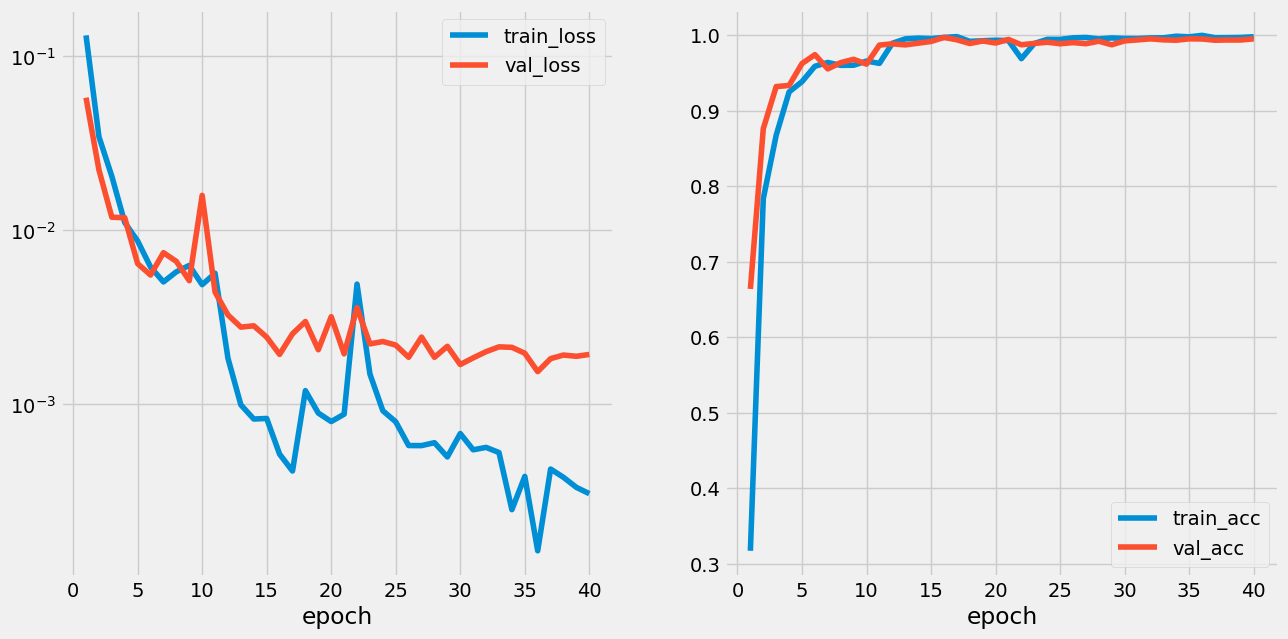

In [43]:
fig, [ax1, ax2] = common_plot_setup(style="fivethirtyeight", font="DejaVu Sans", figsize=(14, 7), rows=1, cols=2)
trainer.complete_results[["train_loss", "val_loss"]].plot(ax=ax1, logy=True)
trainer.complete_results[["train_acc", "val_acc"]].plot(ax=ax2, logy=False)
plt.show()

We can also see where the mistakes came from. In this particular instance, the model had difficulty in distinguishing between ら and う. While the RNN offers greater precision than the CNN it the added freedom of possible values makes generalization more challenging.

In [44]:
misses = IncorrectCharacters(trainer, transformed_dataset, data_paths.get_classes())
print("Characters missed:", len(misses))
misses.overview(5)

Characters missed: 18


label  \
count label   char_id character romanization indices         stroke_count strokes_found pred            
5     hir_ra  ra      ら         ra           7, 8, 9, 10, 11 2            2.0           1       hir_u   
                                                                                        2      hir_ra   
                                                                                        3      hir_ti   
                                                                                        4       hir_o   
                                                                                        5      hir_vu   
3     hir_u   u       う         u            14, 15, 16      2            2.0           1      hir_ra   
                                                                                        2       hir_u   
                                                                                        3      hir_vu   
                                                                                        4     hir_dyu   
                                                                                        5     hir_dya   
2     hir_e   e       え         e            1, 2            2            2.0           1       hir_e   
                                                                                        2      hir_ko   
                                                                                        3      hir_sa   
                                                                                        4      hir_ra   
                                                                                        5       hir_u   
      hir_ko  ko      こ         ko           4, 5            2            2.0           1      hir_sa   
                                                                                        2      hir_go   
                                                                                        3      hir_do   
                                                                                        4      hir_no   
                                                                                        5      hir_tu   
1     hir_dyo dyo     ぢょ        djo          0               6            6.0           1      hir_da   
                                                                                        2     hir_dyo   
                                                                                        3      hir_ze   
                                                                                        4      hir_ga   
                                                                                        5     hir_dya   
      hir_hya hya     ひゃ        hya          3               4            4.0           1      hir_bi   
                                                                                        2     hir_hya   
                                                                                        3      hir_zo   
                                                                                        4     hir_byo   
                                                                                        5      hir_gu   
      hir_mya mya     みゃ        mya          6               5            5.0           1     hir_rya   
                                                                                        2     hir_mya   
                                                                                        3     hir_myu   
                                                                                        4     hir_nyu   
                                                                                        5     hir_tya   
      hir_si  si      し         shi          12              1            1.0           1      hir_hi   
                                                                                        2      hir_no   
 

## Model 3: LSTM + GRU

The next model presents a unique solution to the idea of repeated strokes. Because virtually identical strokes may between several strokes in different positions the model would benefit from a component that extracts information from them independantly.

Rather than use a supervised approach that requires additional training to label and train against commonly occuring shapes and radicals, it is more efficient to use the hidden outputs directly as inputs into a second RNN.

This can be achieved by exploding the strokes into the batch dimension of the first RNN and immediately reshaping the hidden outputs to the original batch and stroke sizes.

When the strokes exist as additional outputs for individual evaluation, the first RNN can generalize the transformation of a stroke regardless of its position but feed the strokes sequentially into a second RNN. This becomes (batch, stroke, points, features) -> (batches and strokes, points, features) for RNN1, while RNN2 takes in (batches, strokes, hidden layers) for it's prediction.

To implement this, I chose an LSTM for the initial layer since the memory of LSTMs provides a distinct advantage when the amount of timesteps is high, but for the second RNN I chose a GRU for faster performance given that the amount of strokes is much smaller in number.

In [45]:
class CharacterIdentifier(nn.Module):
    def __init__(self, lstm_features, lstm_hidden, gru_hidden, num_classes):
        super().__init__()
        self._lstm_hidden = lstm_hidden
        self._gru_hidden = gru_hidden
        self.lstm = nn.LSTM(lstm_features, lstm_hidden, num_layers=1, batch_first=True)
        self.gru = nn.GRU(lstm_hidden, gru_hidden, num_layers=1, batch_first=True)
        self.linear = nn.Linear(gru_hidden, num_classes)
        self.linear_alt = nn.Linear(lstm_hidden, num_classes)
        self.dropout = nn.Dropout(p = 0.1)
        self.lstm_h = (torch.zeros((0)), torch.zeros((0)))
        self.gru_h = torch.zeros((0))
        self.dummy_param = nn.Parameter(torch.empty(0))

    def _init_hidden_state(self, previous, x, hidden_size):
        if tuple(previous.shape) != (1, x.shape[0], hidden_size):
            device = self.dummy_param.device
            return torch.zeros(1, x.shape[0], hidden_size).to(device)
        return previous

    def _init_lstm_hidden_states(self, x):
        h = self._init_hidden_state(self.lstm_h[0], x, self._lstm_hidden)
        if self.lstm_h[0] is not h:
            self.lstm_h = (h, h.clone())

    def _lstm_forward(self, x):
        # Strokes will be converted to batches since this LSTM only needs to learn how to read a shape from a sequence of points.
        batches, strokes, sequence, features = x.shape
        x = x.view(batches * strokes, sequence, features)
        self._init_lstm_hidden_states(x)
        _, (h, c) = self.lstm(x, self.lstm_h)
        out = h.view(batches, strokes, self._lstm_hidden)
        return out, (h, c)

    def _gru_forward(self, x):
        self.gru_h = self._init_hidden_state(self.gru_h, x, self._gru_hidden)
        _, h_g = self.gru(x, self.gru_h)
        out = h_g.view(-1, self._gru_hidden)
        return out, h_g

    def forward(self, inputs):
        out, (h_l, c_l) = self._lstm_forward(inputs)
        out, h_g = self._gru_forward(out)
        out = self.dropout(out)
        out = self.linear(out)
        return out

The data inputs and transformations will be nearly identical here, but in this case there is no longer a need to melt strokes into the feature dimension. The model object handles the reshaping internally to be passed into the LSTM and subsequent GRU.

Unlike the previous model, during training I also noticed that the random gaussian noise tranformation, did not carry a significant positive benefit. This may be due to the fact that when melting the strokes into the batches, the first lstm effictively has an enlarged dataset with a smaller risk of overfitting.

In [46]:
test_transforms = [ToBSplines(120), ArrayToTensor(),
                   ExtractAngles(include_magnitudes=False),
                   InputMinMaxTransformer(None, old_min, old_max, new_min = -1),
                   InputRecenter(None, std_shift),
                  ]
# During testing, the gaussian noise presented no tangible benefits to this model and will be skipped.
train_transforms = transforms.Compose(test_transforms + [EmptyStrokePadder(stroke_count)])
test_transforms = transforms.Compose(test_transforms + [EmptyStrokePadder(stroke_count)])
transformed_dataset = StrokeDataset(data_paths.get_data(), transform=test_transforms)
split_keys = {"train": train_transforms, "val": test_transforms, "test": test_transforms}
split_datapaths = dict(zip(split_keys, data_paths.train_val_test_split(train_size=.7, test_size=.2, random_state=SEED)))
datasets = {key: StrokeDataset(split_datapaths[key], transform=value) for key, value in split_keys.items()}
dataloaders = {key: torch.utils.data.DataLoader(datasets[key], batch_size=batch_size, shuffle=True, num_workers=5, drop_last=True) for key in split_keys.keys()}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ffaef5390d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7ffb13674d50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ffb1349e650>}

In [47]:
lstm_features = 4
lstm_hidden_size = 20
gru_hidden_size = 100
learning_rate=0.004
n_classes = np.unique(full_dataset.labels).size
print(n_classes)

model = CharacterIdentifier(lstm_features, lstm_hidden_size, gru_hidden_size, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.4)

108


In [48]:
trainer = CharacterTrainer(model, optimizer, criterion, dataloaders, scheduler=scheduler, single_input=True)

In [49]:
%%time

trainer.train(40)
trainer.complete_results

       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
1        0.177243   0.115485   5372.0  0.113975  0.270455  448.0  0.004
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
2        0.082312    0.49944   5372.0  0.053163  0.672727  448.0  0.004
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
3        0.044366   0.723694   5372.0  0.032735  0.779545  448.0  0.004
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
4        0.029577    0.80541   5372.0  0.025744  0.829545  448.0  0.004
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                           

,train_loss,train_acc,n_train,val_loss,val_acc,n_val,lr
epoch,,,,,,,
1,0.177243,0.115485,5372,0.113975,0.270455,448,0.004000
2,0.082312,0.499440,5372,0.053163,0.672727,448,0.004000
3,0.044366,0.723694,5372,0.032735,0.779545,448,0.004000
4,0.029577,0.805410,5372,0.025744,0.829545,448,0.004000
5,0.023321,0.842164,5372,0.018366,0.870455,448,0.004000
6,0.019028,0.869963,5372,0.019135,0.861364,448,0.004000
7,0.017630,0.878918,5372,0.013597,0.909091,448,0.004000
8,0.016983,0.882463,5372,0.019387,0.875000,448,0.004000
9,0.016144,0.888246,5372,0.017726,0.877273,448,0.004000


This architecture has a small immediate training/inference speed boost, but also contains the potential for an even larger one in a scenario where real time on screen identification with live feedback is desired. Instead of passing the entire tensor of inputs each time a new stroke is added, the model states could be cached with strokes being passed in in one at a time.

In [50]:
%%time

trainer.test()

       test_loss  test_acc  n_test        lr
epoch                                       
40      0.007008  0.968182   896.0  0.000256
CPU times: user 87.2 ms, sys: 265 ms, total: 353 ms
Wall time: 585 ms


,test_loss,test_acc,n_test,lr
epoch,,,,
40,0.007008,0.968182,896.0,0.000256


While the reduced risk of overfitting allowed the RNN to continue improving for 40 epochs without the addition of the random gaussian noise, the model performs significantly worse in its predictions. One advantage is that despite having two RNNs instead of one the reduced neurons within cut the training time for the same amount of epochs in half. There could be merit in increasing the amount of hidden outputs from the LSTM to better inform the GRU, but an even more interesting possibility would be to make the underlying LSTM inputs more generalizable while passing additional features directly into the GRU.

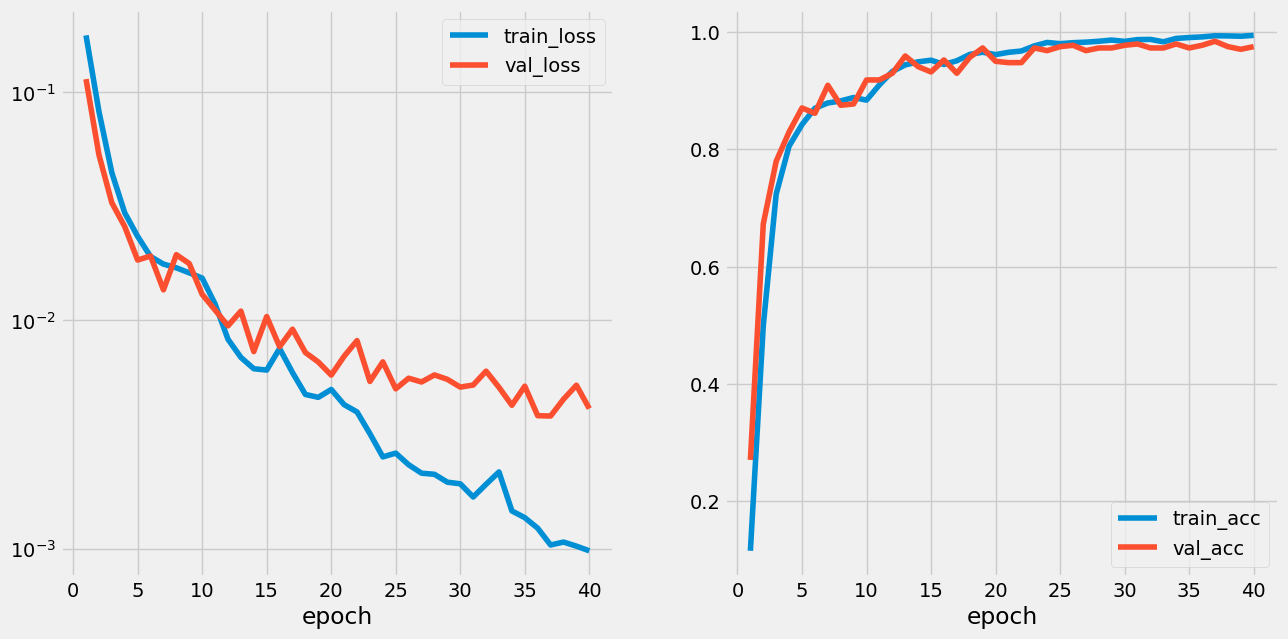

In [51]:
fig, [ax1, ax2] = common_plot_setup(style="fivethirtyeight", font="DejaVu Sans", figsize=(14, 7), rows=1, cols=2)
trainer.complete_results[["train_loss", "val_loss"]].plot(ax=ax1, logy=True)
trainer.complete_results[["train_acc", "val_acc"]].plot(ax=ax2, logy=False)
plt.show()

In the case of this model, the misclassifications happen much more often and there is a stronger bias that hinders the prediction of certain characters (especially う). There is one small advantage in that the count of strokes appears to be more important in the predicitions that are made.

In [52]:
misses = IncorrectCharacters(trainer, transformed_dataset, data_paths.get_classes())
print("Characters missed:", len(misses))
misses.overview(5)

Characters missed: 68


label  \
count label  char_id character romanization indices                                            stroke_count strokes_found pred           
14    hir_tu tu      つ         tsu          40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,... 1            1.0           1     hir_ro   
                                                                                                                          2     hir_tu   
                                                                                                                          3     hir_no   
                                                                                                                          4     hir_vu   
                                                                                                                          5     hir_ra   
...                                                                                                                                ...   
1     hir_wo wo      を         wo           60                                                 3            3.0           1     hir_se   
                                                                                                                          2     hir_wo   
                                                                                                                          3     hir_ti   
                                                                                                                          4      hir_o   
                                                                                                                          5     hir_he   

                                                                                                                                probability  \
count label  char_id character romanization indices                                            stroke_count strokes_found pred                
14    hir_tu tu      つ         tsu          40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,... 1            1.0           1        0.703673   
                                                                                                                          2        0.267252   
                                                                                                                          3        0.027508   
                                                                                                                          4        0.000507   
                                                                                                                          5        0.000272   
...                                                                                                                                     ...   
1     hir_wo wo      を         wo           60                                                 3            3.0           1        0.995950   
                                                                                                                          2        0.002502   
                                                                                                                          3        0.000569   
                                                                                                                          4        0.000268   
                                                                                                                          5        0.000247   

                                                                                                                               char_id  \
count label  char_id character romanization indices                                            stroke_count strokes_found pred           
14    hir_tu tu      つ         tsu          40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,... 1            1.0           1         ro   
                                                            

## Model 4: LSTM + GRU with relative/absolute feature seperation

The last model takes the general idea of model 3 and expands on it further. Instead of passing the raw sequential points and angles into the LSTM, data aggregations are fed directly into the GRU, while more generic centered and scaled inputs are fed into the LSTM.

The data is extracted to form two tensors with the following inputs:
- GRU (using the aggregated strokes as timesteps) inputs:
  - Mean of all X positions
  - Mean of all y positions
  - Standard deviation of all X positions (proxy for stroke length/width since points are sequential)
  - Standard deviation of all y positions (proxy for stroke length/width since points are sequential)
  - Difference between each first x coordinate in the sequence and the mean (additional proxy for length, width and direction).
  - Difference between each first y coordinate in the sequence and the mean (additional proxy for length, width and direction).
  - Difference between each last x coordinate in the sequence and the mean (additional proxy for length, width and direction).
  - Difference between each last y coordinate in the sequence and the mean (additional proxy for length, width and direction).
  - Mean of all sine values between points and their distances (component to measure angular strength continuously)
  - Mean of all cosine values between points and their distances (component to measure angular strength continuously)
  - LSTM hidden layers (the remaining relative data to inform the shape)
- LSTM (using the relative point level data) inputs
  - Normalized sine values after centering against their mean.
  - Normalized cosine values after centering against their mean.
  - Normalized differencing of sine values (measures angular change and can be represented in a single column of values while maintaining its continous nature)
  - Normalized length between points (helps quantify importance between angles)
 
One advantage of this idea is clearly demonstrated when considering a straight line. A whole sequence of drastically different values could be passed into the input of the LSTM for simple reasons such as translation, differences in scale, and rotation. By extracting the aggregate absolute data for direct input into the GRU, a generalization of a given sequence of points is more likely to occur.

Because the inputs will be changing drastically, new aggregated values must be extracted for the purpose of scaling and normalization.

In [53]:
aggregator = StrokeDatasetAggregator(data_paths, transforms.Compose([ToBSplines(120), # In this model all LSTM inputs are derived from differenced point data,
                                                                     ArrayToTensor(),
                                                                     StrokeExtractAbsolute()]), 1 # Class that divides the input tensor into the two sets.
                                    )

Taking the means and standard deviations of points will effectively shift the range of values that was previously -1 to 1. The following code will first create the GRU inputs for the entire dataset and then aggregate values for the purpose of centering and scaling the results before being input into the model.

The relative values fed into the LSTM will be skipped and instead be normalized in respect to each observation.

In [63]:
old_min, old_max = aggregator.get_min_max(dim=0, keepdim=True)

Min: tensor([[-0.8473, -0.6155,  0.0015,  0.0000, -0.9135, -0.5204, -0.6727, -0.9282,
         -0.6701, -0.9993]])
Max: tensor([[0.9361, 0.8746, 0.5997, 0.5980, 0.5269, 1.0623, 1.0578, 0.3485, 0.9999,
         0.2845]])


As expected, the aggregate values have lower ranges than when points were evaluated individually. Once again, the rotational data contains a strong skew from the effect of proper stroke order and will be recentered. In addition recentering is important for the standard deviations since the skew of the values on a -1 to 1 scale will heavily favor the negative since horizontal and vertical strokes with almost no standard deviation along an axis are common and large spacing between points is very uncommon.


In [64]:
means, _ = aggregator.get_mean_std(dim=0, keepdim=True)

Mean: tensor([[ 0.0877,  0.1766,  0.1527,  0.1812, -0.1649,  0.2838,  0.1776, -0.2088,
          0.4164, -0.4831]])
STD: tensor([[0.3846, 0.2809, 0.1202, 0.1570, 0.2173, 0.2877, 0.2460, 0.2223, 0.3681,
         0.3501]])


As with the other model, the recentering will be skipped on the features directly related to the absolute x and y coordinates.

In [65]:
std_means = (means - old_min) / (old_max - old_min) * 2 - 1
print(std_means)
std_shift = f.pad(std_means[:,2:], (2, 0))
print(std_shift)

tensor([[ 0.0485,  0.0631, -0.4945, -0.3941,  0.0395,  0.0163, -0.0174,  0.1269,
          0.3012, -0.1958]])
tensor([[ 0.0000,  0.0000, -0.4945, -0.3941,  0.0395,  0.0163, -0.0174,  0.1269,
          0.3012, -0.1958]])


The custom classes for this model are defined.

In [74]:
class ConformedStrokeDataset(StrokeDataset):
    """Child class of the Stroke Dataset to handle the seperate LSTM and GRU model inputs and apply 0 value padding to the strokes after all other transformations."""
    def __init__(self, path_df, transform, stroke_count):
        super().__init__(path_df, transform)
        self._padder = EmptyStrokePadder(stroke_count)

    def __getitem__(self, idx):
        (relative, absolute), label = super().__getitem__(idx)
        return self._padder(relative), self._padder(absolute), label

class ExtractedCharacterIdentifier(nn.Module):
    def __init__(self, lstm_features, lstm_hidden, gru_additional_features, gru_hidden, num_classes):
        super().__init__()
        self._lstm_hidden = lstm_hidden
        self._gru_hidden = gru_hidden
        self._gru_features = gru_additional_features
        self.lstm = nn.LSTM(lstm_features, lstm_hidden, num_layers=1, batch_first=True)
        self.gru = nn.GRU(lstm_hidden+gru_additional_features, gru_hidden, num_layers=1, batch_first=True)
        self.linear = nn.Linear(gru_hidden, num_classes)
        self.linear_first = nn.Linear(lstm_hidden, lstm_hidden)
        self.dropout = nn.Dropout(p = 0.2)
        self.lstm_h = (torch.zeros((0)), torch.zeros((0)))
        self.gru_h = torch.zeros((0))
        self.dummy_param = nn.Parameter(torch.empty(0))
        self.mish = nn.Mish()

    def _init_hidden_state(self, previous, x, hidden_size):
        if tuple(previous.shape) != (1, x.shape[0], hidden_size):
            device = self.dummy_param.device
            return torch.zeros(1, x.shape[0], hidden_size).to(device)
        return previous

    def _init_lstm_hidden_states(self, x):
        h = self._init_hidden_state(self.lstm_h[0], x, self._lstm_hidden)
        if self.lstm_h[0] is not h:
            self.lstm_h = (h, h.clone())

    def _lstm_forward(self, x):
        # Strokes will be converted to batches since this LSTM only needs to learn how to read a shape from a sequence of points.
        batches, strokes, sequence, features = x.shape
        x = x.view(batches * strokes, sequence, features)
        self._init_lstm_hidden_states(x)
        _, (h, c) = self.lstm(x, self.lstm_h)
        out = h.view(batches, strokes, self._lstm_hidden)
        return out, (h, c)

    def _gru_forward(self, x):
        self.gru_h = self._init_hidden_state(self.gru_h, x, self._gru_hidden)
        _, h_g = self.gru(x, self.gru_h)
        out = h_g.view(-1, self._gru_hidden)
        return out, h_g

    def forward(self, inputs):
        lstm_vals, gru_vals = inputs
        out, (h_l, c_l) = self._lstm_forward(lstm_vals)
        out = torch.cat([gru_vals, out], dim=-1)
        out, h_g = self._gru_forward(out)
        out = self.dropout(out)
        out = self.linear(out)
        return out

In addition to the seperation of features, A small amount of gaussian noise will be added to both inputs. It is stronger on the inputs to the GRU layer since the effective batches for it remain the same. For much of those parameters, the effect can almost be compared to the translation, scaling, and rotation image augmentation techniques of the CNN, but affecting each stroke independently.

In [86]:
test_transforms = [ToBSplines(120), ArrayToTensor(), StrokeExtractAbsolute(),
                   InputNormalizer(0,1), # Normalizes the already relative LSTM inputs for each feature.
                   InputMinMaxTransformer(1, old_min, old_max, new_min = -1), # Normalizes the GRU inputs from -1 to 1 (without adjusting the angle parameters)
                   InputRecenter(1, std_shift) # Recenters the standard deviation features of the GRU inputs to the means within the entire dataset.
                  ]
# Training dataset will be augmented by random transformations.
train_transforms = transforms.Compose(test_transforms + [InputGaussianNoise(0, .04), InputGaussianNoise(1, .1)])
#train_transforms = transforms.Compose(test_transforms +  [InputGaussianNoise(1, .1)])
test_transforms = transforms.Compose(test_transforms)
transformed_dataset = StrokeDataset(data_paths.get_data(), transform=test_transforms)
conformed_dataset = ConformedStrokeDataset(data_paths.get_data(), transform=test_transforms, stroke_count=stroke_count)
split_keys = {"train": train_transforms, "val": test_transforms, "test": test_transforms}
split_datapaths = dict(zip(split_keys, data_paths.train_val_test_split(train_size=.7, test_size=.2, random_state=SEED)))
datasets = {key: ConformedStrokeDataset(split_datapaths[key], transform=value, stroke_count=stroke_count) for key, value in split_keys.items()}
dataloaders = {key: torch.utils.data.DataLoader(datasets[key], batch_size=batch_size, shuffle=True, num_workers=5, drop_last=True) for key in split_keys.keys()}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ffb0bcfc3d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7ffb0bcfcf10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ffb0bcfc050>}

In [87]:
lstm_features = 4
gru_features = 10
lstm_hidden_size = 10
gru_hidden_size = 100
learning_rate=0.005
n_classes = np.unique(full_dataset.labels).size
print(n_classes)

model = ExtractedCharacterIdentifier(lstm_features, lstm_hidden_size, gru_features, gru_hidden_size, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.4)

108


In [88]:
trainer = CharacterTrainer(model, optimizer, criterion, dataloaders, scheduler=scheduler, single_input=False)

In [89]:
%%time

trainer.train(40)
trainer.complete_results

       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
1         0.13963   0.270336   5372.0  0.055159  0.606818  448.0  0.005
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
2        0.038713   0.742724   5372.0  0.016581  0.895455  448.0  0.005
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
3        0.018557   0.883396   5372.0  0.008394  0.945455  448.0  0.005
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                                  
4        0.010794   0.923507   5372.0  0.007102  0.936364  448.0  0.005
       train_loss  train_acc  n_train  val_loss   val_acc  n_val     lr
epoch                                                           

,train_loss,train_acc,n_train,val_loss,val_acc,n_val,lr
epoch,,,,,,,
1,0.139630,0.270336,5372,0.055159,0.606818,448,0.00500
2,0.038713,0.742724,5372,0.016581,0.895455,448,0.00500
3,0.018557,0.883396,5372,0.008394,0.945455,448,0.00500
4,0.010794,0.923507,5372,0.007102,0.936364,448,0.00500
5,0.008575,0.943284,5372,0.007405,0.940909,448,0.00500
6,0.008059,0.948321,5372,0.003769,0.968182,448,0.00500
7,0.006086,0.960261,5372,0.001893,0.988636,448,0.00500
8,0.005367,0.966604,5372,0.002900,0.984091,448,0.00500
9,0.003831,0.979104,5372,0.000903,0.990909,448,0.00500


Training and inference is quicker than the CNN, but the difference less great from time spent during feature extraction. This model closes the accuracy gap greatly, but doesn't quite reach the accuracy of the VGG16 model with transfer learning applied.

In [90]:
%%time

trainer.test()

       test_loss  test_acc  n_test       lr
epoch                                      
40      0.001016  0.996591   896.0  0.00032
CPU times: user 56.3 ms, sys: 276 ms, total: 332 ms
Wall time: 616 ms


,test_loss,test_acc,n_test,lr
epoch,,,,
40,0.001016,0.996591,896.0,0.00032


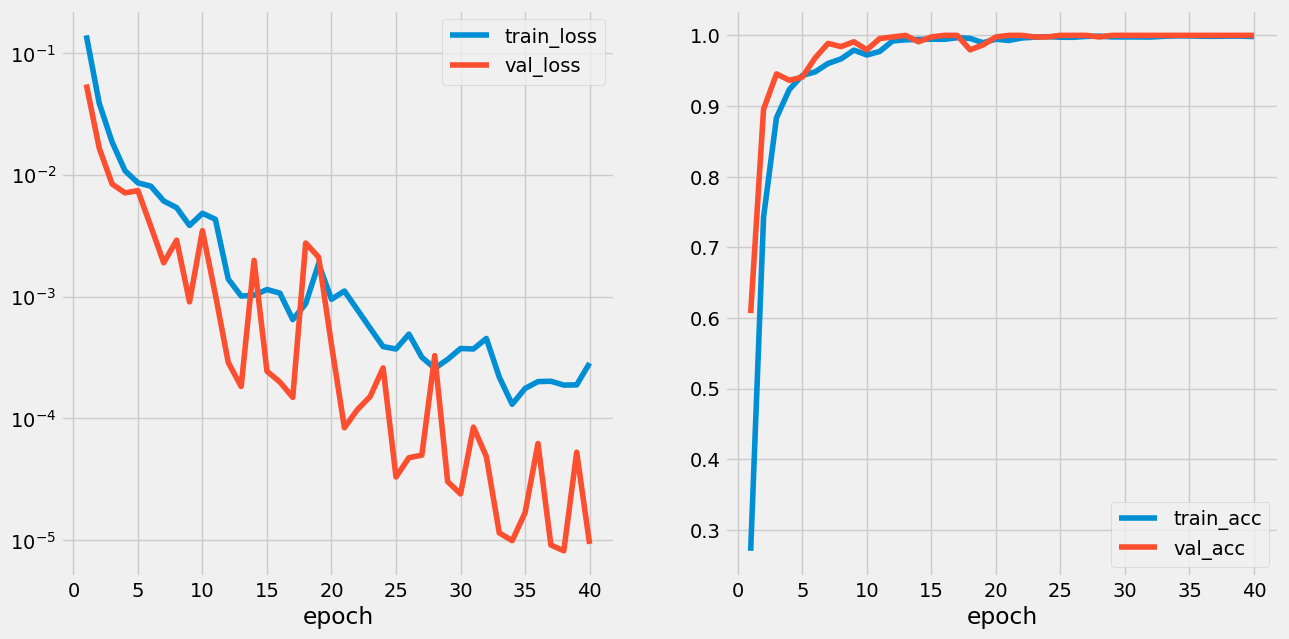

In [91]:
fig, [ax1, ax2] = common_plot_setup(style="fivethirtyeight", font="DejaVu Sans", figsize=(14, 7), rows=1, cols=2)
trainer.complete_results[["train_loss", "val_loss"]].plot(ax=ax1, logy=True)
trainer.complete_results[["train_acc", "val_acc"]].plot(ax=ax2, logy=False)
plt.show()

By examining the outputs when the predicted labels don't match the actual, we can find 3 characters within the dataset to examine in greater detail. The mistaken observations for し and ぞ were very close class among similar shapes, but what was interesting was the misclassification of こ did not even have the correct character in the top 5.

In [92]:
misses = IncorrectCharacters(trainer, conformed_dataset, data_paths.get_classes())
print("Characters missed:", len(misses))
misses.overview(5)

Characters missed: 3


label  \
count label  char_id character romanization indices stroke_count strokes_found pred           
1     hir_ko ko      こ         ko           0       2            2.0           1      hir_e   
                                                                               2      hir_u   
                                                                               3     hir_ra   
                                                                               4     hir_to   
                                                                               5     hir_zo   
      hir_si si      し         shi          1       1            1.0           1      hir_n   
                                                                               2     hir_si   
                                                                               3     hir_ku   
                                                                               4     hir_ha   
                                                                               5     hir_ru   
      hir_zo zo      ぞ         zo           2       3            3.0           1     hir_de   
                                                                               2     hir_zo   
                                                                               3     hir_bi   
                                                                               4      hir_i   
                                                                               5     hir_du   

                                                                                     probability  \
count label  char_id character romanization indices stroke_count strokes_found pred                
1     hir_ko ko      こ         ko           0       2            2.0           1        0.999464   
                                                                               2        0.000268   
                                                                               3        0.000177   
                                                                               4        0.000018   
                                                                               5        0.000014   
      hir_si si      し         shi          1       1            1.0           1        0.557691   
                                                                               2        0.388516   
                                                                               3        0.034469   
                                                                               4        0.016394   
                                                                               5        0.001736   
      hir_zo zo      ぞ         zo           2       3            3.0           1        0.581675   
                                                                               2        0.416614   
                                                                               3        0.000636   
                                                                               4        0.000471   
                                                                               5        0.000161   

                                                                                    char_id  \
count label  char_id character romanization indices stroke_count strokes_found pred           
1     hir_ko ko      こ         ko           0       2            2.0           1          e   
                                                                               2          u   
                                                                               3         ra   
                                                                               4         to   
                                                                               5         zo   
      hir_si si      し         shi          1       1            1.0           1          n   
         

Examining it in more detail, it can be seen that the shape and stroke order is technically correct, it is a bit different from the rest of the dataset due to being drawn by a different contributor whose presence was rare in the dataset. The model would have much to gain from an increased diversity of contributers because the current data is made entirely from the contributions of two individuals where one person was responsible for roughly 98% of the observations.

(    label char_id character romanization stroke_count  strokes_found
9  hir_ko      ko         こ           ko            2              2,      label  probability char_id character romanization stroke_count
3    hir_e     0.999464       e         え            e            2
2    hir_u     0.000268       u         う            u            2
38  hir_ra     0.000177      ra         ら           ra            2
19  hir_to     0.000018      to         と           to            2
55  hir_zo     0.000014      zo         ぞ           zo            3)


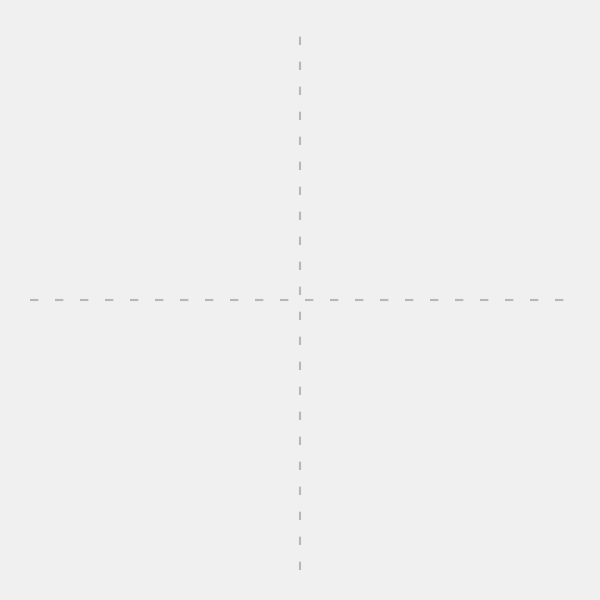

    label char_id character romanization stroke_count  strokes_found
9  hir_ko      ko         こ           ko            2              2


'../data/choubenkyo_data/hir_ko_2_kay_0000.json'

In [95]:
%matplotlib widget
i = 0
print(misses.compare(i, 5))
misses.examine(i, force_stop_previous=True)

## Conclusion

The refinements to the process have greatly improved accuracy in comparison to the earlier prototype.

Based on the results in this notebook and the advantages and disadvantages presented, there is strong incentive to further develop the idea of model 4 as the strategy in the event of a continued project and expanded scope. While the VGG16 transfer learned CNN was impressive and outclassed the other models, the ability to fully utilize the sequential data would likely outpace it under the assumption of an expanded dataset and classes and outperform its implementation.

The next step for a more robust model would likely be best served in exploring additional refinements to the training process. Most notably diversifying away from padding all observations to a fixed amount of strokes, but instead dynamically training complete unpadded characters augmented by clipped and padded variations that maintain a reasonable balance of classes.